# Exploratory Data Analysis (EDA)

## Overview
This section is dedicated to **Exploratory Data Analysis (EDA)**, where we explore the historical stock data for major Canadian banks.  

### **Steps in this analysis:**
1. **Data Loading from the Database**
2. **Basic Statistical Summary**
3. **Skewness & Kurtosis Check**
4. **Kernel Density Estimation (KDE)**
5. **Stock Close Price Trends Over Time**
6. **Moving Averages (SMA & EMA)**
7. **Volatility Analysis**
8. **Volume of Shares Traded**
9. **Stock Price Comparison Among Banks**
10. **Stock Price Correlation Among Banks**

Each step provides insights into how the stock prices behave and interact across different banks.


## 1. Data Loading from the Database
The stock data is stored in a **PostgreSQL database**. We load it into a Pandas DataFrame using SQL queries.

**Columns in the dataset:**
- `bank_name`: The bank's name (BMO, RBC, TD, CIBC, Scotiabank)
- `date`: The trading date
- `close_price`: The closing price of the stock
- `high_price`, `low_price`, `open_price`: Daily price range
- `volume`: Number of shares traded

In [33]:
from sqlalchemy import create_engine
import pandas as pd
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Database credentials from .env
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create database connection
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Query all data for 5 banks and multiple years
query = """
SELECT s.bank_name, sp.date, sp.close_price, sp.high_price, sp.low_price, sp.open_price, sp.volume
FROM stock_prices as sp 
JOIN stocks as s ON s.ticker=sp.stock_ticker ;
"""
df = pd.read_sql(query, engine)

# Display first few rows
print(df.head())  


  bank_name        date  close_price  high_price  low_price  open_price  \
0       BMO  2020-01-03    80.279427   80.335287  79.593141   79.880423   
1       BMO  2020-01-06    80.215599   80.239544  79.856499   79.888420   
2       BMO  2020-01-07    80.079941   80.622585  80.048020   80.239546   
3       BMO  2020-01-08    80.662498   81.101398  80.199653   80.215611   
4       BMO  2020-01-09    80.957748   81.213110  80.702387   80.997651   

    volume  
0  1473000  
1  1147500  
2   702000  
3  1088400  
4  1683900  


## 2. Basic Statistical Summary
Understanding the dataset through summary statistics helps detect anomalies and understand price distributions.

**Key statistics include:**
- **Mean**: Average stock price
- **Median**: Middle value, less sensitive to outliers
- **Standard Deviation (std)**: Measures stock price fluctuations
- **Min & Max**: Highest and lowest recorded prices

In [37]:
#data shepe and data information about the column types
print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns\n")
df.info()

Data has 6273 rows and 7 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6273 entries, 0 to 6272
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bank_name    6273 non-null   object 
 1   date         6273 non-null   object 
 2   close_price  6273 non-null   float64
 3   high_price   6273 non-null   float64
 4   low_price    6273 non-null   float64
 5   open_price   6273 non-null   float64
 6   volume       6273 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 343.2+ KB


In [ ]:
#As column "Date" is of an object type, it has to be converted to the date format
df['date'] = pd.to_datetime(df['date'])
df.dtypes


bank_name              object
date           datetime64[ns]
close_price           float64
high_price            float64
low_price             float64
open_price            float64
volume                  int64
dtype: object

In [39]:
#Checking for the missing values
df.isnull().sum()

bank_name      0
date           0
close_price    0
high_price     0
low_price      0
open_price     0
volume         0
dtype: int64

In [41]:
# Basic statistics for numerical columns
print(df.describe())



                                date  close_price   high_price    low_price  \
count                           6273  6273.000000  6273.000000  6273.000000   
mean   2022-07-01 15:24:25.136298240    80.389468    80.931078    79.811136   
min              2020-01-02 00:00:00    25.911804    28.073357    25.877310   
25%              2021-04-01 00:00:00    56.463879    56.818015    56.027343   
50%              2022-06-30 00:00:00    73.648445    74.145484    73.155671   
75%              2023-10-02 00:00:00   109.846405   110.574856   109.124842   
max              2024-12-31 00:00:00   179.570007   180.449997   178.440002   
std                              NaN    30.385350    30.516353    30.213970   

        open_price        volume  
count  6273.000000  6.273000e+03  
mean     80.359042  4.175782e+06  
min      27.440987  2.157000e+05  
25%      56.456757  2.257200e+06  
50%      73.643317  3.363200e+06  
75%     109.903316  5.103700e+06  
max     179.940002  2.883860e+07  
std     

In [42]:
# Checking for duplicates
duplicate_rows_df = df[df.duplicated()]

if duplicate_rows_df.empty: 
    print("There are no duplicates")
else:
    print("Number of duplicate rows:", duplicate_rows_df.shape[0])


There are no duplicates


BMO: Number of outliers in closing price: 67
CIBC: Number of outliers in closing price: 59
TD: Number of outliers in closing price: 193
Scotiabank: Number of outliers in closing price: 198
RBC: Number of outliers in closing price: 70


C:\Users\MiF\AppData\Local\Temp\ipykernel_15960\3718963735.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="bank_name", y="close_price", data=df, palette='Set2')


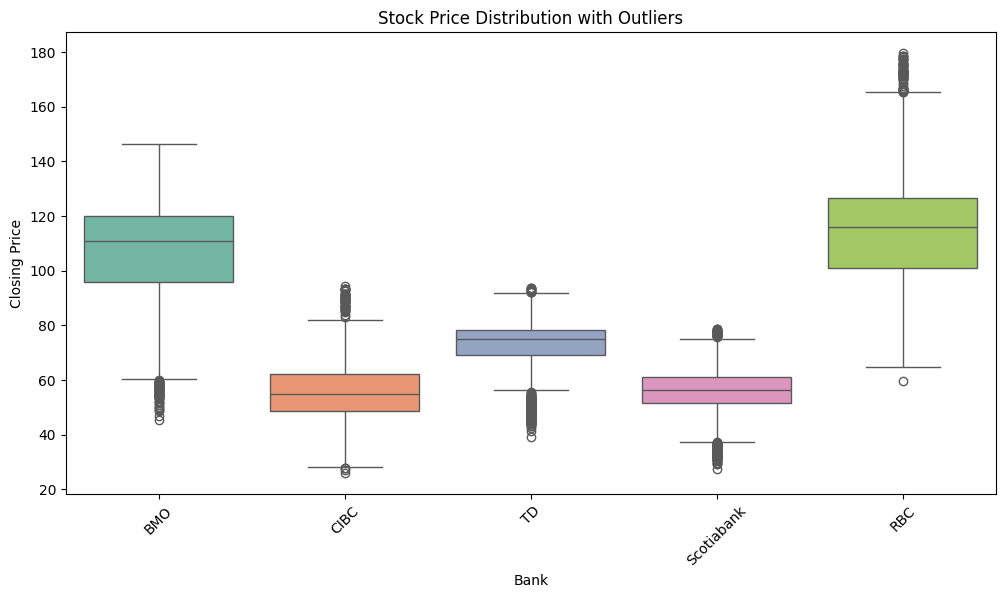

In [44]:
#detecting outliers in close_prise for each bank
import seaborn as sns
import matplotlib.pyplot as plt

#Loop goes through each bank and detects outliers using interquartile range (IQR) approach
for bank in df["bank_name"].unique():
    bank_df = df[df["bank_name"] == bank]
    
    Q1 = bank_df["close_price"].quantile(0.25)
    Q3 = bank_df["close_price"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = bank_df[(bank_df["close_price"] < lower_bound) | (bank_df["close_price"] > upper_bound)]
    
    print(f"{bank}: Number of outliers in closing price: {outliers.shape[0]}")


#Outliers visualisation
plt.figure(figsize=(12, 6))
sns.boxplot(x="bank_name", y="close_price", data=df, palette='Set2')
plt.title("Stock Price Distribution with Outliers")
plt.xlabel("Bank")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.show()


#### Outliers handling: 
**Because outliers represent real events (e.g. COVID=19 in 2020), We will keep them further volatility analysis and business decisions**

### 3. Skewness & Kurtosis Check  

To better understand the distribution of stock prices, we analyze **skewness** and **kurtosis**, which provide insights into the shape and characteristics of the data.  

- **Skewness** measures the **asymmetry** of the distribution.  
  - A **positive** skew indicates a longer tail on the **right** (higher values).  
  - A **negative** skew suggests a longer tail on the **left** (lower values).  
  - A skewness close to **0** means the data is approximately **symmetrical**.  

- **Kurtosis** evaluates the **tailedness** (extreme values) of the distribution.  
  - A **high kurtosis** (leptokurtic) implies more extreme values (outliers).  
  - A **low kurtosis** (platykurtic) indicates fewer extreme values.  
  - A kurtosis value around **3** suggests a normal distribution.  

#### **Why This Matters?**  
Stock prices with significant skewness or high kurtosis may indicate unusual price movements, potential volatility, or the need for data transformation before modeling.  

#### **Next Steps:**  
- If skewness is high, we may consider **log transformation** or **Box-Cox transformation** to normalize the data.  
- If kurtosis is excessive, it suggests **more outliers**, which may need further investigation.  


In [46]:
from scipy.stats import skew, kurtosis

# Calculate skewness and kurtosis for close price for the whole dataset
skew_close_all = skew(df["close_price"], nan_policy='omit')  # Avoid issues with NaNs
kurt_close_all = kurtosis(df["close_price"], nan_policy='omit')

print("Overall skewness and kurtosis")
print("Close price Skewness:", skew_close_all)
print("Close price Kurtosis:", kurt_close_all)

# Interpretation of skewness
if -0.1 <= skew_close_all <= 0.1:
    print("The distribution is symmetric, no extreme prices or outliers.")
elif 0.5 <= skew_close_all <= 1:
    print("Moderate positive skewness, meaning there are a few extremely high close prices.")
elif -1 <= skew_close_all <= -0.5:
    print("Moderate negative skewness, meaning there are a few extremely low close prices.")
elif skew_close_all > 1:
    print("High positive skewness, meaning there are many extremely high close prices.")
elif skew_close_all < -1:
    print("High negative skewness, meaning there are many extremely low close prices.")
else:
    print("Slight skewness, but not significant.")

# Interpretation of kurtosis
if kurt_close_all < -1:
    print("Low kurtosis (platykurtic): Distribution has light tails and fewer extreme values.")
elif -1 <= kurt_close_all <= 1:
    print("Normal kurtosis (mesokurtic): Close price distribution is similar to a normal distribution.")
elif kurt_close_all > 1:
    print("High kurtosis (leptokurtic): Distribution has heavy tails and more extreme values.")




Overall skewness and kurtosis
Close price Skewness: 0.6303684665007772
Close price Kurtosis: -0.3649060170401919
Moderate positive skewness, meaning there are a few extremely high close prices.
Normal kurtosis (mesokurtic): Close price distribution is similar to a normal distribution.


In [47]:
# Calculation Skewness and kurtosis for each bank

for bank in df["bank_name"].unique():
    bank_df = df[df["bank_name"] == bank] 
    
    skew_close = skew(bank_df["close_price"], nan_policy='omit')
    kurt_close = kurtosis(bank_df["close_price"], nan_policy='omit')

    print(f"\nBank: {bank}")
    print("Close price Skewness:", skew_close)
    print("Close price Kurtosis:", kurt_close)

    # Skewness interpretation
    if -0.1 <= skew_close <= 0.1:
        print("The distribution is symmetric, no extreme prices or outliers.")
    elif 0.5 <= skew_close <= 1:
        print("Moderate positive skewness, meaning there are a few extremely high close prices.")
    elif -1 <= skew_close <= -0.5:
        print("Moderate negative skewness, meaning there are a few extremely low close prices.")
    elif skew_close > 1:
        print("High positive skewness, meaning there are many extremely high close prices.")
    elif skew_close < -1:
        print("High negative skewness, meaning there are many extremely low close prices.")
    else:
        print("Slight skewness, but not significant.")

    # Kurtosis interpretation
    if kurt_close < -1:
        print("Low kurtosis (platykurtic): Distribution has light tails and fewer extreme values.")
    elif -1 <= kurt_close <= 1:
        print("Normal kurtosis (mesokurtic): Close price distribution is similar to a normal distribution.")
    elif kurt_close > 1:
        print("High kurtosis (leptokurtic): Distribution has heavy tails and more extreme values.")



Bank: BMO
Close price Skewness: -0.9861595049259944
Close price Kurtosis: -0.050476559071645166
Moderate negative skewness, meaning there are a few extremely low close prices.
Normal kurtosis (mesokurtic): Close price distribution is similar to a normal distribution.

Bank: CIBC
Close price Skewness: 0.5400604342365133
Close price Kurtosis: 0.7728147960583986
Moderate positive skewness, meaning there are a few extremely high close prices.
Normal kurtosis (mesokurtic): Close price distribution is similar to a normal distribution.

Bank: TD
Close price Skewness: -0.9472104022492269
Close price Kurtosis: 0.04664374644159075
Moderate negative skewness, meaning there are a few extremely low close prices.
Normal kurtosis (mesokurtic): Close price distribution is similar to a normal distribution.

Bank: Scotiabank
Close price Skewness: -0.5115911846269319
Close price Kurtosis: -0.10012507411835747
Moderate negative skewness, meaning there are a few extremely low close prices.
Normal kurtosis

### **Step 4: Kernel Density Estimation (KDE)**
Kernel Density Estimation (KDE) is used to visualize the probability distribution of a dataset. Unlike histograms, KDE provides a smooth estimate of the data distribution, making it easier to detect skewness, modality, and outliers. 

In this step, we will analyze the distribution of closing prices for different banks using KDE plots.


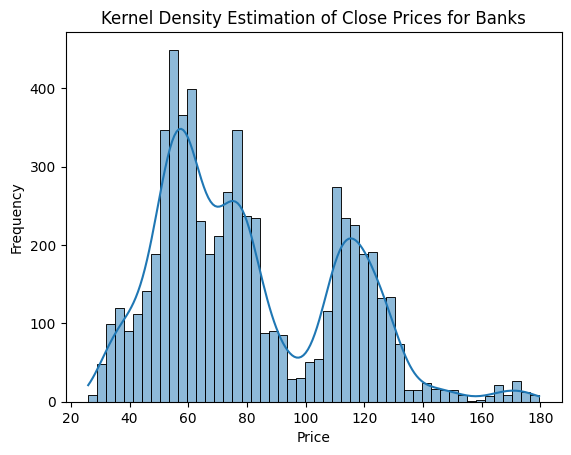

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

#KDE for the whole dataset to see a general picture
sns.histplot(df["close_price"], kde=True, bins=50)
plt.title("Kernel Density Estimation of Close Prices for Banks")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


#### KDE Explanation
The distribution of close prices for all banks exhibits multiple peaks, indicating that the data is not normally distributed. This suggests that stock prices fall into distinct groups, likely representing different pricing tiers among banks.

To further analyze these variations, we will examine the KDE for each bank separately in the next step. This will help us determine whether specific banks contribute to the observed peaks and identify any patterns within individual stock price distributions

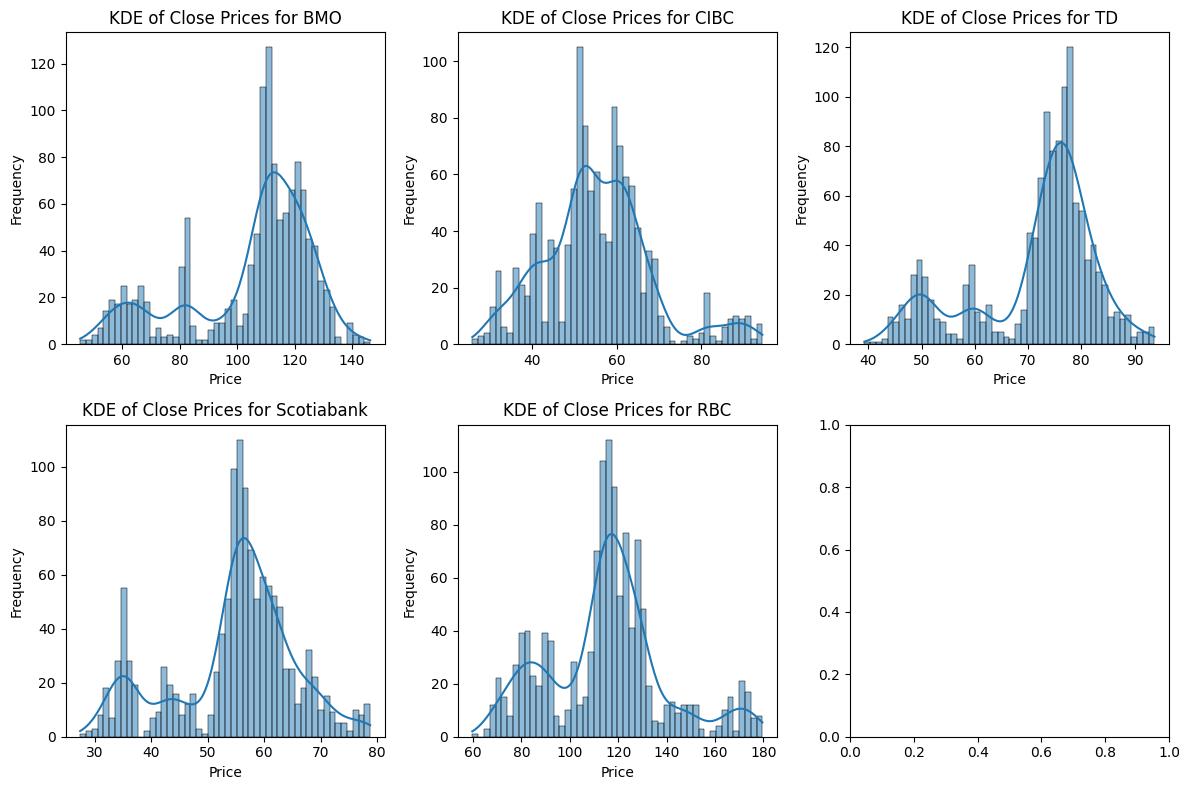

In [60]:
#KDE for each bank separately
banks = df["bank_name"].unique()
num_banks = len(banks)

# Determine the grid size 
rows = int(np.ceil(num_banks / 3))  
cols = min(3, num_banks) 

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))  

for i, bank in enumerate(banks):
    row, col = divmod(i, cols)
    ax = axes[row, col] if rows > 1 else axes[col]  
    sns.histplot(df[df["bank_name"] == bank]["close_price"], bins=50, kde=True, ax=ax)
    ax.set_title(f"KDE of Close Prices for {bank}")
    ax.set_xlabel("Price")
    ax.set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()


### **Kernel Density Estimation of Close Prices for Banks**  

The distribution of closing prices for all banks exhibits multiple peaks, indicating that the data is **not normally distributed**. This suggests that stock prices have undergone different phases, likely due to market conditions or internal financial performance.  

#### **Key Observations:**  
- **Price Ranges:**  
  - **RBC** has the widest range (~60 to ~180), indicating higher price dispersion.  
  - **BMO and TD** show prices mostly between **50 and 140**, while **CIBC and Scotiabank** remain below **100**.  
- **Multi-Peak Distributions:**  
  - **BMO, RBC, and TD** exhibit **distinct bimodal or trimodal peaks**, suggesting significant price fluctuations.  
  - **CIBC and Scotiabank** show a smoother distribution, indicating relatively stable price movements.  
- **Volatility Indications:**  
  - **RBC and BMO** have wider distributions, implying **higher volatility**.  
  - **Scotiabank and CIBC** have a more concentrated price range, suggesting **lower fluctuations**.  

### **Next Steps:**  
- **Trend Visualization:** Examine stock price movements over time to identify patterns.  
- **Volatility Analysis:** Calculate standard deviations and price change rates to quantify risk levels.  


## **5. Stock Close Price Trends Over Time**  

Understanding stock price trends is essential for identifying **long-term growth patterns, market cycles, and potential turning points**. By analyzing the closing prices over time, we can:  

- Detect **upward or downward trends** in individual banks.  
- Identify periods of **high volatility or stability**.  
- Compare price movements across banks to assess **relative performance**.  

This analysis will provide deeper insights into how stock prices evolve, helping us assess market behavior and potential influencing factors.  


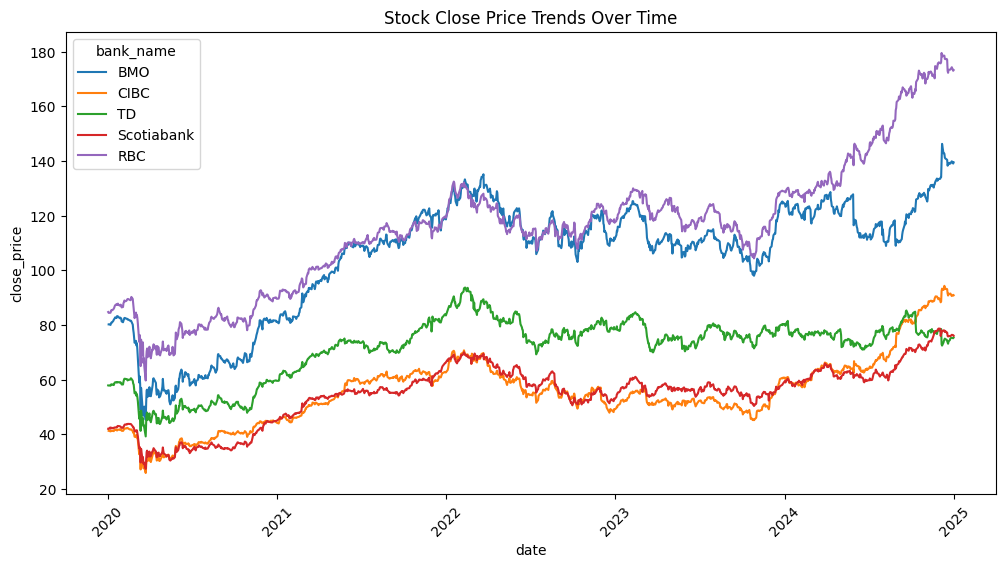

In [63]:
plt.figure(figsize=(12,6))
sns.lineplot(x="date", y="close_price", hue="bank_name", data=df)
plt.title("Stock Close Price Trends Over Time")
plt.xticks(rotation=45)
plt.show()

### Understanding trends:
The period under analysis includes 2020, when the global economy was significantly impacted by the COVID-19 pandemic, resulting in a sharp decline in stock prices for all five banks. Following the first quarter of 2020, stock prices for all banks exhibited a steady increase until the beginning of 2022.

In the first half of 2022, stock prices experienced a small to moderate decline, continuing through the end of 2023. This could be attributed to the ongoing uncertainty as markets adjusted to post-pandemic conditions and inflationary pressures. However, by 2025, stock prices for CIBC, Scotiabank, and TD had recovered, reaching levels comparable to the peak in 2022. This suggests that these banks have managed to adapt to changing market conditions and have capitalized on economic recovery, reflecting improved investor confidence.

BMO’s stock price showed even stronger growth, surpassing the 2022 peak, indicating that the bank may have benefited from more aggressive growth strategies or stronger operational performance relative to its competitors. RBS, on the other hand, demonstrated the most significant growth, showing notable improvement over the entire 5-year period. This could suggest that RBS has been better positioned to leverage long-term growth opportunities, possibly benefiting from strategic initiatives or increased market share in key areas.

## **6. Calculating Moving Averages:**
Moving averages are widely used in financial analysis to smooth out short-term fluctuations and highlight longer-term trends in stock prices. By averaging the price data over a specified period, moving averages help to identify trends more clearly and reduce the impact of volatility. In this analysis, we will calculate moving averages for the stock prices of the five banks, using different time windows to assess their performance over both short and long-term horizons. This will provide additional insights into the underlying trends and assist in evaluating the overall market behavior during the analyzed period.


Moving Averages (SMA & EMA)
- SMA (Simple Moving Average) shows the general trend by averaging past prices.
- EMA (Exponential Moving Average) reacts faster to price changes and is more sensitive to recent trends

How to interpret?
- Price above SMA/EMA → Uptrend (bullish signal)
- Price below SMA/EMA → Downtrend (bearish signal)
- Golden Cross (Short-term MA crosses above Long-term MA) → Bullish
- Death Cross (Short-term MA crosses below Long-term MA) → Bearish

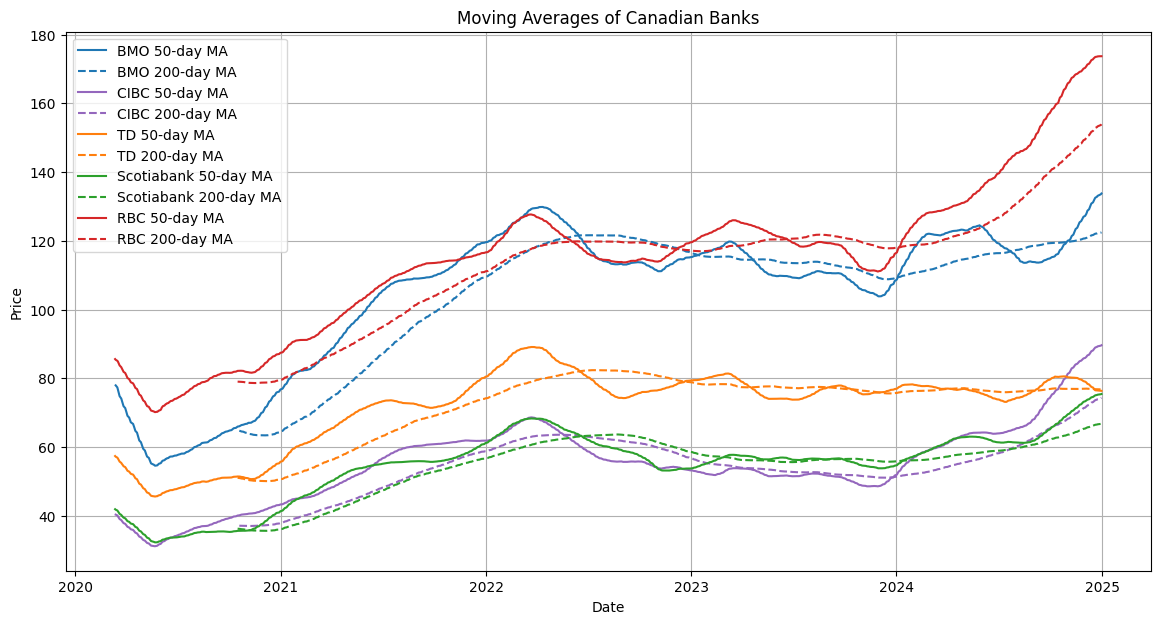

In [66]:
# Moving averages for 50-day and 200-day windows
df['50_day_MA'] = df.groupby('bank_name')['close_price'].rolling(window=50).mean().reset_index(0, drop=True)
df['200_day_MA'] = df.groupby('bank_name')['close_price'].rolling(window=200).mean().reset_index(0, drop=True)

# Define colors for each bank (5 different colors)
colors = ['#1f77b4', '#9467bd', '#ff7f0e', '#2ca02c', '#d62728' ]

# Plot the moving averages with dashed lines for the 200-day MA
plt.figure(figsize=(14, 7))

for i, bank in enumerate(df['bank_name'].unique()):
    bank_data = df[df['bank_name'] == bank]
    # Plot 50-day MA as solid line
    plt.plot(bank_data['date'], bank_data['50_day_MA'], label=f'{bank} 50-day MA', color=colors[i])
    # Plot 200-day MA as dashed line
    plt.plot(bank_data['date'], bank_data['200_day_MA'], label=f'{bank} 200-day MA', color=colors[i], linestyle='--')

plt.title('Moving Averages of Canadian Banks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


### **Trend Interpretation and Investment Inferences:**
**From the analysis of the moving averages, several patterns emerge that can inform investment decisions:**

**Short-Term vs. Long-Term Trend:**

**General Observation:** For four out of the five banks, the short-term moving average (50-day) is above the long-term moving average (200-day) by the end of 2024. This indicates a strong bullish sentiment for these banks, suggesting that their stock prices are trending upward in the short term and outpacing the long-term growth.
Exception (TD Bank): TD Bank is the only bank where the short-term moving average is below the long-term moving average at the end of 2024. This may signal a more cautious or bearish outlook for TD’s stock in the short term, suggesting that investors might need to monitor it closely for any potential recovery or risk of further decline.
Period 2012 - Q1 2022:

**Consistent Bullish Trend:** Between 2012 and the first quarter of 2022, all five banks maintained a pattern of the short-term moving average being above the long-term moving average, reflecting consistent growth and stability in the stock prices. This period likely corresponds to a stable economic environment and solid performance across the banking sector.
Fluctuations in 2022-2024:

**Increased Volatility:** From the beginning of 2022 to the start of 2024, the moving averages fluctuate, with short-term averages crossing above and below the long-term averages. This suggests a period of uncertainty or market volatility, possibly due to the ongoing recovery from the COVID-19 pandemic, inflationary pressures, and broader economic challenges.
Investment Implication: Investors during this period might have seen mixed signals, with frequent reversals indicating higher market risk. For risk-averse investors, this might have been a period to stay cautious, while more aggressive investors could have taken advantage of these fluctuations for short-term gains.
Recovery and Growth (End of 2023 - End of 2024):

**Strong Trend for Most Banks:** By the end of 2024, all banks, except for TD, show a positive trend with their short-term moving averages above the long-term ones. This is a bullish sign, indicating strong short-term growth compared to longer-term performance.
BMO's Performance: BMO still shows some fluctuation but ends the year on a positive note, suggesting that while it may face some challenges, the general trend is improving. For investors, this may imply that BMO is in a recovery phase and could offer potential upside, albeit with more volatility compared to the other banks.

**Investment Recommendation:** For investors seeking stability and growth, **CIBC, Scotiabank, and RBC appear to be good candidates** as their short-term trends are firmly above long-term averages. BMO also shows promise despite its fluctuations, while TD might require a more cautious approach due to its underperformance in the short term.

## **7. Volatility Analysis**  

Volatility measures how much stock prices fluctuate over time. It helps answer:
✔ How risky is a stock? Higher volatility = larger price swings = riskier investment.
✔ Is the market stable or uncertain? Low volatility = stable trend, high volatility = unpredictable.
✔ When to invest? Investors may prefer low-volatility stocks for long-term stability, but traders might seek high volatility for short-term gains.

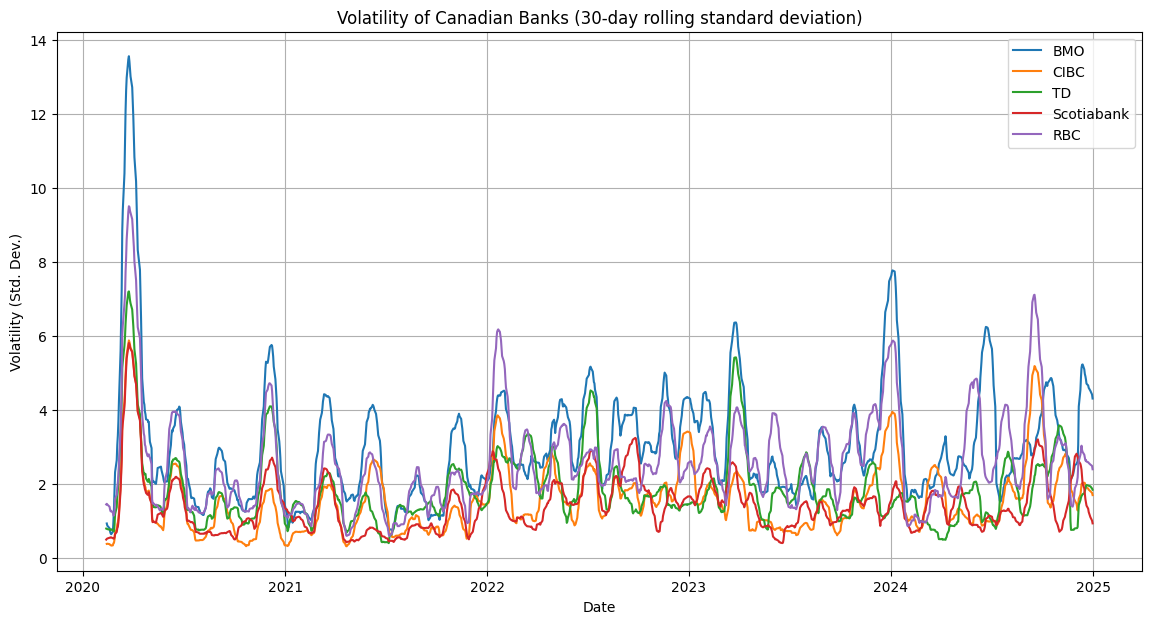

In [67]:
# Calculate rolling standard deviation (30 days) for each bank
df['volatility'] = df.groupby('bank_name')['close_price'].rolling(window=30).std().reset_index(0, drop=True)

# Plot volatility over time for each bank
plt.figure(figsize=(14, 7))
for bank in df['bank_name'].unique():
    bank_data = df[df['bank_name'] == bank]
    plt.plot(bank_data['date'], bank_data['volatility'], label=bank)

plt.title('Volatility of Canadian Banks (30-day rolling standard deviation)')
plt.xlabel('Date')
plt.ylabel('Volatility (Std. Dev.)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\MiF\AppData\Local\Temp\ipykernel_15960\1535329639.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="bank_name", y="volatility", data=df, palette="Set2")


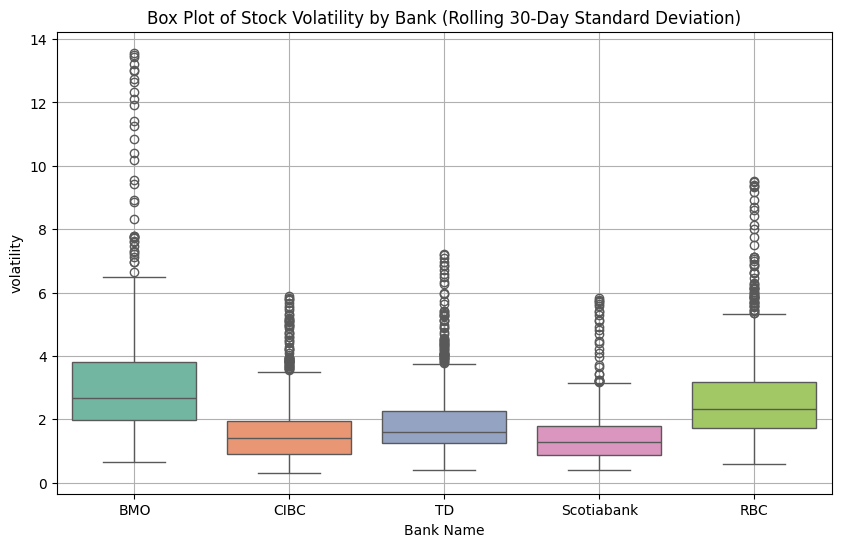

In [69]:
# Drop NaN values (rolling std introduces NaNs at the beginning)
df = df.dropna(subset=["volatility"])

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="bank_name", y="volatility", data=df, palette="Set2")

# Labels and title
plt.title("Box Plot of Stock Volatility by Bank (Rolling 30-Day Standard Deviation)")
plt.ylabel("volatility")
plt.xlabel("Bank Name")
plt.grid(True)

# Show plot
plt.show()


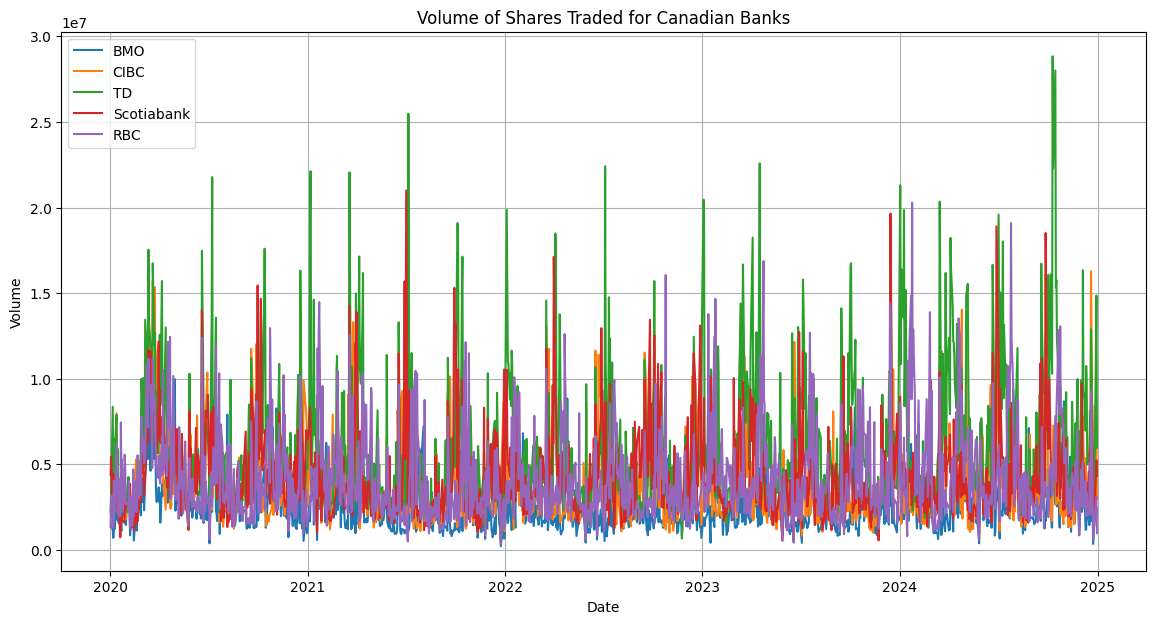

In [19]:
#Volume analysis

plt.figure(figsize=(14, 7))
for bank in df['bank_name'].unique():
    bank_data = df[df['bank_name'] == bank]
    plt.plot(bank_data['date'], bank_data['volume'], label=bank)


plt.title('Volume of Shares Traded for Canadian Banks')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


Bank Comparison 

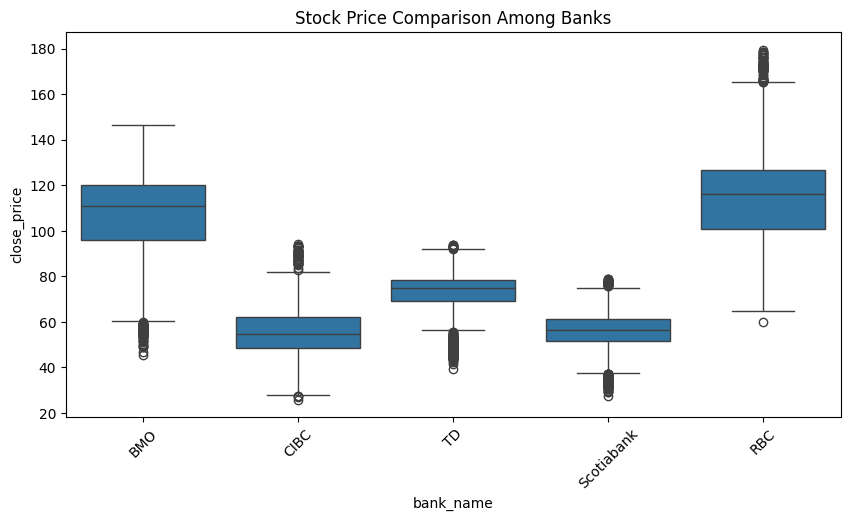

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(x="bank_name", y="close_price", data=df)
plt.title("Stock Price Comparison Among Banks")
plt.xticks(rotation=45)
plt.show()

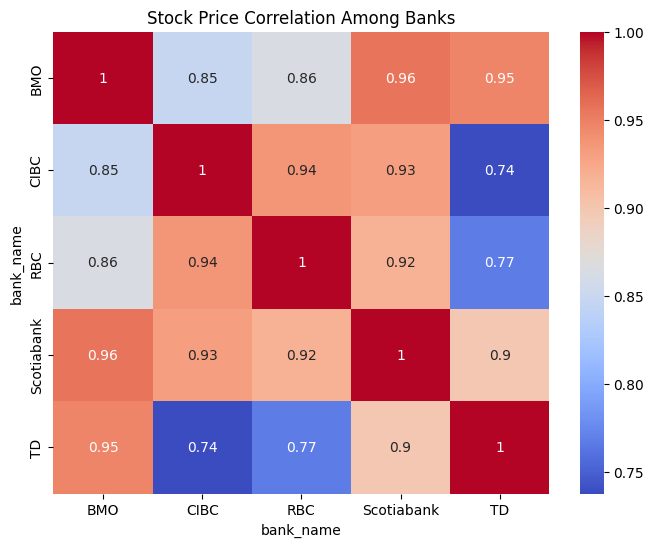

In [27]:
df_pivot = df.pivot(index="date", columns="bank_name", values="close_price")
correlation_matrix = df_pivot.corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Stock Price Correlation Among Banks")
plt.show()
